# Analyzing Reddit Comments Sentiment using MistralAI and LangGraph

## Overview

This notebook was created by Shay Elmualem ([Github](https://github.com/norbinsh/), [Linkedin](https://www.linkedin.com/in/shay-elmualem/))
This notebook analyzes the sentiment of Reddit post comments using LangGraph and MistralAI's large language model (LLM).
It fetches Reddit posts, processes comments, performs sentiment analysis, and visualizes the results through a graph-based workflow.

## Brief

- Fetches a Reddit post and its comments.
- Analyzes each comment's sentiment using MistralAI's LLM.
- Aggregates sentiments to determine the overall sentiment of the discussion.
- Visualizes the workflow and results with LangGraph and Rich.

## Components

- Reddit Client: Uses praw to interact with Reddit's API.
- Data Models: Structured representations with pydantic.
- Language Model: MistralAI's LLM for sentiment analysis.
- Prompt Template: Guides the LLM for consistent analysis.
- Graph Workflow: Managed by LangGraph for process sequencing.
- Visualization: Displays results using rich.

## Setup and Installation

Install necessary packages with:

In [121]:
%pip install -q langchain==0.3.13
%pip install -q langchain_community==0.3.13
%pip install -q langchain-mistralai==0.2.4
%pip install -q langgraph==0.2.60
%pip install -q praw==7.8.1
%pip install -q python-dotenv==1.0.1
%pip install -q pydantic==2.10.4
%pip install rich==13.9.4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Required Environment Variables

Create a .env file with:

- MISTRAL_API_KEY
- REDDIT_PRAW_CLIENT_ID
- REDDIT_PRAW_CLIENT_SECRET

Or use the helper function in the notebook to set them interactively.

In [122]:
from dotenv import load_dotenv
import os, getpass
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")
_set_env("REDDIT_PRAW_CLIENT_ID")
_set_env("REDDIT_PRAW_CLIENT_SECRET")

## Imports

All necessary libraries are imported at the beginning for clarity:

In [123]:
import os
import re
import json

import praw

from rich import print
from rich.console import Console
from rich.table import Table
import textwrap

from typing import TypedDict, Annotated, List, Optional, Dict, Literal
from pydantic import BaseModel, HttpUrl, ValidationError, Field, RootModel

from langgraph.graph import Graph, END
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.tools import StructuredTool

from IPython.display import display, Image as IPImage

from langchain_mistralai import ChatMistralAI



## Reddit Client Setup

Initialize the Reddit client with praw:

In [124]:
REDDIT_USER_AGENT = "RedditCommentsSentimentAgent"
MAX_COMMENT_SAMPLES = 10
MAX_EXPANDED_COMMENTS = 0

reddit = praw.Reddit(
    client_id=os.environ.get("REDDIT_PRAW_CLIENT_ID"),
    client_secret=os.environ.get("REDDIT_PRAW_CLIENT_SECRET"),
    user_agent=REDDIT_USER_AGENT,
)

## Data Models

Define Reddit's structured data models using pydantic:

In [125]:
class Comment(BaseModel):
    body: str

class CommentSentiment(BaseModel):
    sentiment_reason: str
    sentiment_score: float # Ranging from -1 to 1, where -1 is very negative, 0 is neutral, and 1 is very positive

class CommentSentiments(BaseModel):
    sentiments: List[CommentSentiment]

class RedditPost(BaseModel):
    title: str
    body: str
    comments: List[Comment]

## Reddit Data Handling Functions

Functions to extract and fetch Reddit posts:

In [126]:
def extract_post_id(url: HttpUrl) -> str:
    pattern = r"comments/([\w\d]+)/"
    match = re.search(pattern, str(url))
    if match:
        return match.group(1)
    else:
        raise ValueError("Invalid Reddit post URL.")

def fetch_post(post_id: str) -> RedditPost:
    post = reddit.submission(id=post_id)
    post.comments.replace_more(limit=MAX_EXPANDED_COMMENTS)
    comments = [
        Comment.model_validate({"body": comment.body})
        for comment in post.comments.list()[:MAX_COMMENT_SAMPLES]
    ]

    return RedditPost(
        title=post.title,
        body=post.selftext,
        comments=comments
    )

# Language Model Configuration

Configure MistralAI's LLM:

In [127]:
mistral_model = "mistral-large-latest"
llm = ChatMistralAI(model=mistral_model, temperature=0)

# Testing the LLM

Verify LLM functionality:

In [128]:
test_llm = llm.invoke("thoughts on life on mars? keep it very brief :)").content
print(test_llm)

Life on Mars is a fascinating topic. Here are some brief thoughts:

- **Past Life**: Many scientists believe that Mars had liquid water and a denser atmosphere billions of years ago, 
which could have supported microbial life.
- **Present Life**: Current conditions are harsh, but some extremophiles on Earth could theoretically survive 
Martian conditions, so it's not ruled out.
- **Future Life**: Mars could potentially be habitable for humans with terraforming, but that's a long-term and 
controversial prospect.
- **Missions**: Rovers like Perseverance are currently exploring Mars to seek signs of ancient life and prepare for
future human exploration.

# Sentiment Analysis Pipeline

## Prompt Template

Define the prompt for sentiment analysis:

In [129]:
template = """
You are an expert in sentiment analysis, specifically for social media content. Your task is to analyze the sentiment of comments on a Reddit post, considering the context of the original post.

Here are the comments you'll be analyzing:

{comments}

Now, read the Reddit post these comments are responding to:

Title: <reddit_post_title>{reddit_post_title}</reddit_post_title>

Body: <reddit_post_body>{reddit_post_body}</reddit_post_body>

For each comment, follow these steps:

1. Read the comment carefully.
2. Consider how the comment relates to the original post.
3. Analyze the sentiment, taking into account:
   - The language used
   - Any emotional expressions
   - The context of the original post
4. Identify and quote key phrases that indicate sentiment.
5. Consider both positive and negative aspects of the comment.
6. Determine a sentiment score from -1 (very negative) to 1 (very positive), where 0 is neutral.
7. Provide a brief explanation of the sentiment.

IMPORTANT: Respond ONLY with a JSON object containing a "sentiments" key. The value of "sentiments" should be an array of objects, each representing the analysis for a comment. The response should NOT include any other fields like 'post_summary'.

The JSON object should be in the following format:
{{
  "sentiments": [
    {{
      "sentiment_reason": "Reason for sentiment",
      "sentiment_score": 0.5
    }},
    {{
      "sentiment_reason": "Another reason",
      "sentiment_score": -0.3
    }}
  ]
}}
"""

## Structured Output

Ensure consistent JSON output:

In [130]:
structured_llm = llm.with_structured_output(CommentSentiments, method="json_mode")

## Graph State Management

Define the graph's state structure:

In [131]:
class GraphState(TypedDict):
    url: str
    post: RedditPost
    comment_sentiments: CommentSentiments
    overall_sentiment: float
    is_valid: bool

## Agent Functions

Functions executed by the agent:

In [132]:


def fetch_reddit_content(state: GraphState) -> GraphState:
    post_id = extract_post_id(state["url"])
    fetched_post = fetch_post(post_id)
    assert isinstance(fetched_post, RedditPost), f"fetch_post returned {type(fetched_post)}"
    state["post"] = fetched_post
    return state

def validate_reddit_content(state: GraphState) -> GraphState:
    state["is_valid"] = bool(state["post"].comments)
    return state

def determine_path(state: GraphState) -> str:
    return "analyze" if state["is_valid"] else END

def calculate_overall_sentiment(state: GraphState) -> GraphState:
    sentiments = [s.sentiment_score for s in state["comment_sentiments"].sentiments]
    state["overall_sentiment"] = sum(sentiments) / len(sentiments) if sentiments else 0.0
    return state

def analyze_comment_sentiment(state: GraphState) -> GraphState:
    prompt = PromptTemplate(template=template)
    chain = prompt | structured_llm 
    
    formatted_comments = "\n\n".join(
        f"Comment {i+1}:\n{comment.body}" for i, comment in enumerate(state["post"].comments)
    )

    result = chain.invoke({
        "reddit_post_title": state["post"].title,
        "reddit_post_body": state["post"].body,
        "comments": formatted_comments
    })

    try:
        state["comment_sentiments"] = result
    except ValidationError as e:
        print("Custom Validation Error in CommentSentiments:", e)
        raise

    return state

## Result Visualization

Display results using rich:

In [133]:
console = Console()

def print_analysis(state: GraphState) -> GraphState:
    console.print("\n[bold underline]Reddit Comment Sentiment Analysis[/bold underline]\n")
    console.print(f"[bold]Post:[/bold] {state['post'].title}\n")
    console.print("[bold]Individual Comments Analysis:[/bold]")
    
    table = Table(show_header=True, header_style="bold white")
    table.add_column("Comment", style="dim", width=10)
    table.add_column("Sentiment")
    table.add_column("Reason", overflow="fold")
    
    for i, (comment, sentiment) in enumerate(zip(state['post'].comments, state['comment_sentiments'].sentiments), 1):
        score = sentiment.sentiment_score
        if score > 0.1:
            sentiment_display = f"[green]😊 {score:+.1f}[/green]"
        elif score < -0.1:
            sentiment_display = f"[red]😞 {score:+.1f}[/red]"
        else:
            sentiment_display = f"[yellow]😐 {score:+.1f}[/yellow]"
        
        wrapped_reason = textwrap.fill(sentiment.sentiment_reason, width=50)
        
        table.add_row(str(i), sentiment_display, wrapped_reason)
    
    console.print(table)
    
    overall_score = state['overall_sentiment']
    if overall_score > 0.1:
        overall_display = f"[green]😊 {overall_score:+.2f}[/green]"
    elif overall_score < -0.1:
        overall_display = f"[red]😞 {overall_score:+.2f}[/red]"
    else:
        overall_display = f"[yellow]😐 {overall_score:+.2f}[/yellow]"
    
    console.print(f"\n[bold]Overall Sentiment Score:[/bold] {overall_display}")
    
    return state

## Graph Workflow

Define and compile the workflow graph:

In [134]:
def create_sentiment_graph():
    workflow = Graph()
    workflow.set_entry_point("fetch")

    workflow.add_node("fetch", fetch_reddit_content)
    workflow.add_node("validate", validate_reddit_content)
    workflow.add_node("analyze", analyze_comment_sentiment)
    workflow.add_node("calculate", calculate_overall_sentiment)
    workflow.add_node("print", print_analysis)

    workflow.add_edge("fetch", "validate")
    workflow.add_edge("analyze", "calculate")
    workflow.add_edge("calculate", "print")
    workflow.add_edge("print", END)

    workflow.add_conditional_edges(
        source="validate",
        path=determine_path,
        path_map={"analyze": "analyze", END: END}
    )

    return workflow.compile()

## Graph Visualization

Visualize the workflow graph:

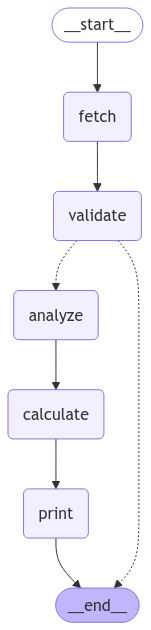

In [135]:
graph = create_sentiment_graph()

display(
    IPImage(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Executing the Workflow

Run the graph with an initial state.
Feel free to change the Reddit post URL in the `initial_state` to analyze different posts comments.

In [136]:
initial_state = GraphState(
    url="https://www.reddit.com/r/devops/comments/1hir6a5/jenkins_or_girhub_actions/",
    post=RedditPost(
        title="",
        body="",
        comments=[]
    ),
    comment_sentiments=[],
    overall_sentiment=0.0,
    is_valid=False
)

result = graph.invoke(initial_state)

Reddit Comment Sentiment Analysis

Post: Jenkins or Girhub Actions

Individual Comments Analysis:

┏━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Comment    ┃ Sentiment ┃ Reason                                             ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1          │ 😊 +0.3   │ The comment suggests GitHub Actions over Jenkins,  │
│            │           │ indicating a positive sentiment towards GitHub     │
│            │           │ Actions and a slightly negative sentiment towards  │
│            │           │ Jenkins. Key phrases: 'suggest GitHub actions',    │
│            │           │ 'Jenkins... has been gradually fading'.            │
│ 2          │ 😊 +0.5   │ The comment strongly favors GitHub Actions and     │
│            │           │ criticizes Jenkins for being outdated and having   │
│            │           │ security risks. Key phrases: 'GitHub actions',     │
│            │           │ 'Jenkins is just outdated', 'huge security risks'. │
│ 3          │ 😐 +0.0   │ The comment is neutral and simply suggests GitLab  │
│            │           │ without any emotional language or criticism. Key   │
│            │           │ phrase: 'GitLab'.                                  │
│ 4          │ 😐 +0.0   │ The comment is neutral and advises considering the │
│            │           │ business case rather than popularity. Key phrases: │
│            │           │ 'The right tech isn't always a popularity          │
│            │           │ contest', 'make the business case'.                │
│ 5          │ 😊 +0.2   │ The comment favors GitLab for its extensibility    │
│            │           │ and criticizes Jenkins for being too complex. It   │
│            │           │ is neutral towards GitHub Actions. Key phrases:    │
│            │           │ 'GitLab does', 'Jenkins is too complex'.           │
│ 6          │ 😞 -0.3   │ The comment criticizes both GitHub Actions and     │
│            │           │ Jenkins, but more heavily criticizes Jenkins. Key  │
│            │           │ phrases: 'GitHub Actions is far from perfect',     │
│            │           │ 'Jenkins is an operational and security            │
│            │           │ nightmare'.                                        │
│ 7          │ 😐 +0.0   │ The comment suggests using GitHub/Gitea actions    │
│            │           │ for building and Jenkins for deployment, showing a │
│            │           │ mixed sentiment. Key phrases: 'github/gitea        │
│            │           │ actions for building stuff', 'jenkins for          │
│            │           │ deployment'.                                       │
│ 8          │ 😐 +0.0   │ The comment is neutral and simply suggests GitHub  │
│            │           │ Actions. Key phrase: 'GHA'.                        │
│ 9          │ 😞 -0.5   │ The comment is negative towards Jenkins without    │
│            │           │ suggesting an alternative. Key phrase: 'Not        │
│            │           │ Jenkins'.                                          │
│ 10         │ 😐 +0.0   │ The comment is neutral and describes the use of    │
│            │           │ both Jenkins and GitHub Actions during a           │
│            │           │ transition period. Key phrases: 'legacy one is     │
│            │           │ still on Jenkins', 'new one is using GA'.          │
└────────────┴───────────┴────────────────────────────────────────────────────┘

Overall Sentiment Score: 😐 +0.02

# Summary

This notebook integrates LangGraph and MistralAI's LLM to perform sentiment analysis on Reddit comments.
It fetches posts, analyzes sentiments, aggregates results, and visualizes the workflow, providing insights into community sentiments effectively and efficiently.